# importing required libraries


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import preprocessing


In [13]:
# Helper function to convert dataset to a NumPy array
def dataset_to_numpy(dataset, batch_size):
    images = []
    labels = []
    dataset = dataset.unbatch().batch(batch_size)
    for image_batch, label_batch in dataset.as_numpy_iterator():
        images.append(image_batch)
        labels.append(label_batch)
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images.reshape(images.shape[0], -1), labels  # Flatten images

In [14]:
# Load datasets
IMAGE_SIZE = (224, 224)

dataset_training = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Dataset/train',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=32)

dataset_valid = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Dataset/valid',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=32)


dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Dataset/test',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=32)




Found 713 files belonging to 3 classes.
Found 128 files belonging to 3 classes.
Found 367 files belonging to 3 classes.


In [15]:

# Convert datasets to NumPy arrays
X_train, y_train = dataset_to_numpy(dataset_training, 32)
X_val, y_val = dataset_to_numpy(dataset_valid, 32)
X_test, y_test = dataset_to_numpy(dataset_test, 32)


In [16]:
from sklearn.decomposition import IncrementalPCA
import numpy as np

# Parameters
n_components = 32
batch_size = 32

# Initialize Incremental PCA
ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)

# Assuming X_train is your dataset
for batch in np.array_split(X_train, len(X_train) // batch_size):
    ipca.partial_fit(batch)  # Fit IPCA incrementally



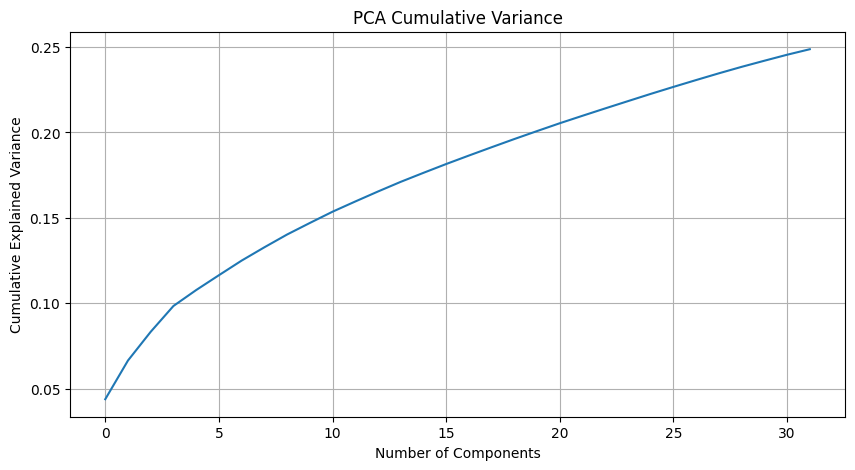

In [17]:
# Transform the data
X_train_pca = ipca.transform(X_train)
X_val_pca = ipca.transform(X_val)
X_test_pca = ipca.transform(X_test)

# You can also plot the cumulative variance if needed
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(ipca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Variance')
plt.grid(True)
plt.show()


In [18]:
# Random Forest classifier and grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt'],
    'max_depth': [4, 6, 8, 10],
    'criterion': ['gini', 'entropy']
}

#Training

##RF with Advanced Usage with Grid Search and Parallel Processing

In [30]:
# Initialize the classifier and perform grid search
rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=1, n_jobs=1)

# Fit model with thread-based parallel processing
with parallel_backend('threading', n_jobs=-1):
    grid_search.fit(X_train_pca, np.argmax(y_train, axis=1))  # Use argmax to convert one-hot to labels

# Evaluate the model using PCA-transformed data
best_clf = grid_search.best_estimator_
y_train_pred = best_clf.predict(X_train_pca)  # Corrected line
y_pred = best_clf.predict(X_val_pca)

# Print evaluation metrics
print("Best Parameters:", grid_search.best_params_)
training_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred)
print("Classification Report:\n", classification_report(np.argmax(y_val, axis=1), y_pred))
print("Training Accuracy:", training_accuracy)

# Calculate and print validation and test accuracies
val_accuracy = accuracy_score(np.argmax(y_val, axis=1), y_pred)
print("Validation Accuracy:", val_accuracy)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), best_clf.predict(X_test_pca))  # Convert one-hot to labels for accuracy
print("Testing Accuracy:", test_accuracy)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.10      0.14        51
           1       0.62      0.13      0.22        38
           2       0.27      0.69      0.39        39

    accuracy                           0.29       128
   macro avg       0.38      0.31      0.25       128
weighted avg       0.37      0.29      0.24       128

Training Accuracy: 0.9985974754558204
Validation Accuracy: 0.2890625
Testing Accuracy: 0.5286103542234333


#Testing

## Calculating Testing Accuracy

In [40]:
from sklearn.metrics import accuracy_score

# Assuming clf is your trained classifier and you have already used it to predict
y_pred = best_clf.predict(X_test_pca)


y_test_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print("Testing Accuracy:", accuracy)


Testing Accuracy: 0.5286103542234333


#Model Summary

In [41]:
print("Best Model Summary:")
print(best_clf)

Best Model Summary:
RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)
